In [114]:
import autograd.numpy as np
from autograd import elementwise_grad
import numpy.linalg as la
from scipy.sparse import spdiags

import matplotlib.pyplot as plt
colors = [(0,0.4,1),(1,0.7,0.3),(0.2,0.7,0.2),(0.8,0,0.2),(0.5,0.3,.9)]

In [134]:
# Parameters
eta = 6.0
gamma = 1.0

t_max = 2
c = 1.4 # the speed and two times the height of the wave
P = 20  # period
M = 100  # number of spatial points
N = 100 # number of temporal points

In [135]:
# Utility functions
def grid(P=20, M=100):
    dx = P/M
    x = np.linspace(0, P-dx, M)
    return x, dx

sech = lambda a: 1/np.cosh(a) # sech isn't defined in NumPy

# Simple analytic Soliton

In [136]:
x, dx = grid(P, M)
u_soliton = lambda x, t: 1/2*c*sech(np.abs((x-c*t) % P - P/2))**2

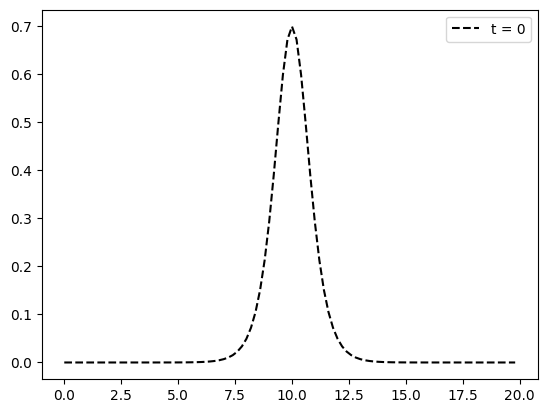

In [137]:
plt.plot(x, u_soliton(x, 0), 'k--', label='t = 0'); plt.legend();

# Non-analytic Solitons

In [418]:

g = lambda x, t: 0
f = lambda u, t: -np.matmul(D1, .5*eta*u**2 + gamma**2*np.matmul(D2,u)) + g(x, t)
Df = lambda u: -np.matmul(D1, eta*np.diag(u) + gamma**2*D2)


In [419]:
# Utility functions
def difference_matrices(P=20, M=100):
    dx = P/M
    e = np.ones(M) # unit vector of length M
    # 1st order central difference matrix:
    D1 = .5/dx*spdiags([e,-e,e,-e], np.array([-M+1,-1,1,M-1]), M, M).toarray()
    # 2nd order central difference matrix:
    D2 = 1/dx**2*spdiags([e,e,-2*e,e,e], np.array([-M+1,-1,0,1,M-1]), M, M).toarray()
    return D1, D2

def midpoint_method(u, un, t ,f ,Df ,dt ,M ,tol ,max_iter):
    '''
    Integrating one step of the ODE u_t = f, from u to un,
    with the implicit midpoint method
    Using Newton's method to find un
    '''
    I = np.eye(M)
    F = lambda u_hat: 1/dt*(u_hat-u) - f((u+u_hat)/2, t+.5*dt)
    J = lambda u_hat: 1/dt*I - 1/2*Df((u+u_hat)/2)
    err = la.norm(F(un))
    it = 0
    while err > tol:
        un = un - la.solve(J(un),F(un))
        err = la.norm(F(un))
        it += 1
        if it > max_iter:
            print("Newton's method didn't converge after {} iterations".format(max_iter))
            break
    return un

In [469]:
def initial_condition_kdv(x, k1, k2, eta):
    M = x.size
    P = int((x[-1]-x[0])*M/(M-1))

    d1, d2 = .15, .4
    sech = lambda a: 1/np.cosh(a) # sech isn't defined in NumPy
    u0 = 0
    u0 += (-6./-eta)*2 * k1**2 * sech(np.abs(k1 * ((x+P/2-P*d1) % P - P/2)))**2
    u0 += (-6./-eta)*2 * k2**2 * sech(np.abs(k2 * ((x+P/2-P*d2) % P - P/2)))**2
    u0 = np.concatenate([u0[M:], u0[:M]], axis=-1)
    return u0

In [525]:
# Parameters
eta = 6.0
gamma = 1.0

t_max = 19
c = 2 # the speed and two times the height of the wave
P = 50  # period
M = 200  # number of spatial points
N = 50 # number of temporal points

k1= 0.70 # upper=0.7, lower
k2 = .3 # upper= 0.5, lower
# Grids
x, dx = grid(P, M) # spatial grid
t, dt = grid(t_max, N) # temporal grid

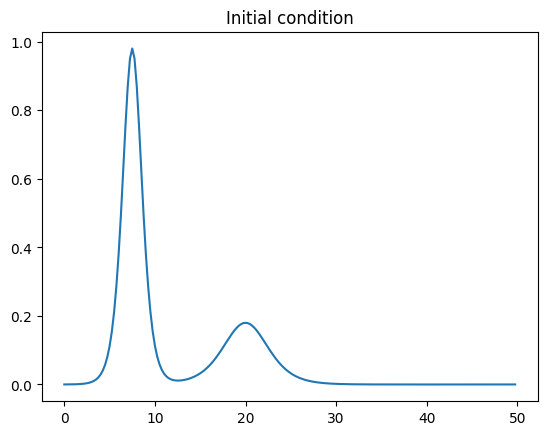

In [526]:
D1, D2 = difference_matrices(P,M)
u0 = initial_condition_kdv(x, k1, k2, eta)
plt.plot(x, u0); plt.title('Initial condition');

In [527]:
%%time
u = np.zeros([t.shape[0], u0.shape[-1]])
u[0, :] = u0
# The implicit midpoint method:
for i, t_step in enumerate(t[:-1]):
    u[i+1,:] = midpoint_method(u[i,:], u[i,:], t[i], f, Df, dt, M, 1e-12, 10)

CPU times: user 9.6 s, sys: 831 ms, total: 10.4 s
Wall time: 1.85 s


MovieWriter ffmpeg unavailable; using Pillow instead.


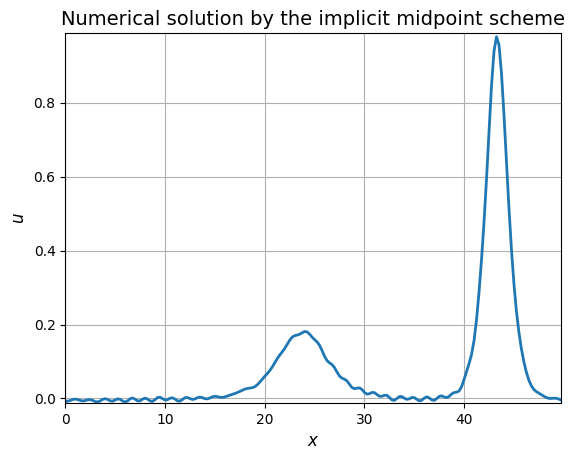

In [528]:
from matplotlib import animation, rc
rc('animation', html='jshtml')
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.set_xlim((x[0], x[-1]))
ax.set_ylim((u.min(), u.max()))
ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel('$u$', fontsize=12)
ax.set_title('Numerical solution by the implicit midpoint scheme', fontsize=14)
ax.grid()
def init():
    line.set_data([], [])
    return (line,)
def animate(i):
    line.set_data(x, u[i,:])
    return (line,)
ani = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=u.shape[0], interval=200, blit=True)
ani.save('implicit_midpoint.gif', fps=30)

In [529]:
import torch
import scipy
def energy_conservation(u, dx, eta, gamma):
    """
    Returns the energy conservation error for the KdV equation
    u: solution tensor of shape (batch_size, time_steps, M)
    M: number of spatial points
    dx: spatial step size
    eta: model specific parameter
    gamma: model specific parameter
    :returns: energy conservation error tensor of shape (batch_size, time_steps) for each time step
    """
    M = u.size(-1)
    device = u.device
    e = np.ones(M)
    Dp = .5 / dx * scipy.sparse.spdiags([e, -e, e, -e], np.array([-M + 1, -1, 1, M - 1]), M, M).toarray()
    Dp = torch.tensor(Dp, dtype=torch.float32, device=device)

    H = lambda u: dx*torch.sum(-1/6*eta*u**3 + (.5*gamma**2*torch.matmul(Dp,u.transpose(1, 2)).transpose(1, 2)**2), dim=2)
    Ht = H(u)
    return torch.abs(Ht - Ht[:, 0, None])

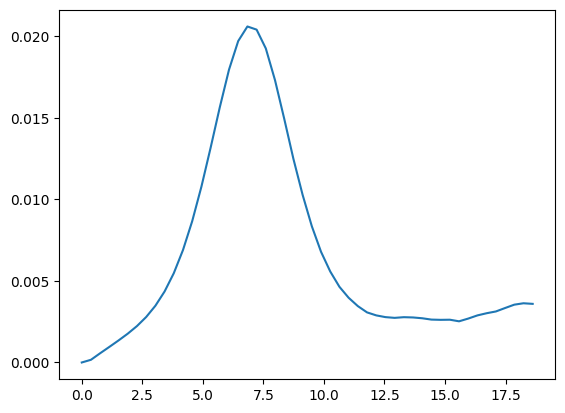

In [530]:
energy = energy_conservation(torch.tensor(u[None, :, :], dtype=torch.float  ), dx, eta, gamma)
plt.plot(t, energy[0, :].detach().numpy())

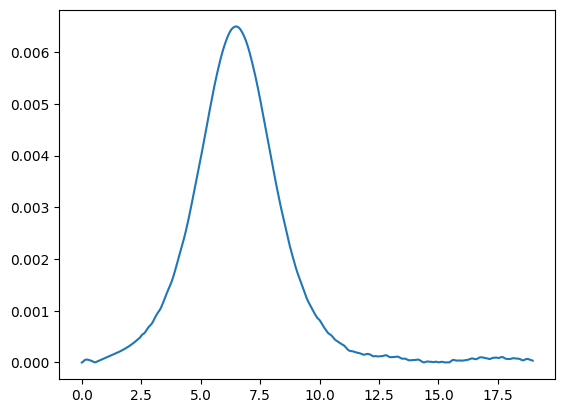

In [524]:
energy = energy_conservation(torch.tensor(u[None, :, :], dtype=torch.float  ), dx, eta, gamma)
plt.plot(t, energy[0, :].detach().numpy())